## 1. Importing Libraries

In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras import Model

## 2. Setting Constants

In [2]:
# Constants
BASE_DIR = r"E:\NEW_FOLDER\Projects_Java_Python\Plant Disease Detection\archive\plantvillage dataset"
TARGET_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 5  # Increase for better accuracy

## 3. Getting Dataset Path

In [3]:
# Switch case-like function for directories
def get_dataset_path(mode):
    if mode == "color":
        return os.path.join(BASE_DIR, "color")
    elif mode == "greyscale":
        return os.path.join(BASE_DIR, "grayscale")
    elif mode == "segmented":
        return os.path.join(BASE_DIR, "segmented")
    else:
        raise ValueError("Invalid mode. Choose from 'color', 'greyscale', or 'segmented'.")

## 4. Splitting Dataset into Train and Test

In [4]:
# Splitting dataset into train/test
def split_dataset(dataset_path, output_path, test_size=0.3):
    classes = os.listdir(dataset_path)
    for cls in classes:
        cls_path = os.path.join(dataset_path, cls)
        images = os.listdir(cls_path)

        # Train-test split
        train_images, test_images = train_test_split(images, test_size=test_size, random_state=42)

        for img_set, folder in [(train_images, "train"), (test_images, "test")]:
            target_dir = os.path.join(output_path, folder, cls)
            os.makedirs(target_dir, exist_ok=True)
            for img in img_set:
                shutil.copy(os.path.join(cls_path, img), os.path.join(target_dir, img))

# 5. Building the Model

## ii. Pretrained Models(ResNet, VGGNet)

In [5]:
# Build a model using pre-trained ResNet or VGGNet
def build_model(num_classes, base_model_type):
    if base_model_type == 'ResNet':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3))
    elif base_model_type == 'VGG':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3))
    else:
        raise ValueError("base_model_type must be 'ResNet' or 'VGG'")
    
    # Freeze the convolutional base
    base_model.trainable = False

    # Add custom top layers
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=x)
    
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [6]:
# Train and evaluate the model
def train_and_evaluate(mode, base_model_type):
    dataset_path = get_dataset_path(mode)
    output_path = os.path.join(BASE_DIR, f"processed_{mode}")
    
    # Split dataset (if not already split)
    # split_dataset(dataset_path, output_path)

    # Directories for train and test
    train_dir = os.path.join(output_path, "train")
    test_dir = os.path.join(output_path, "test")

    # Data augmentation for training
    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    # Rescaling for testing
    test_datagen = ImageDataGenerator(rescale=1.0 / 255)

    # Data generators
    train_gen = train_datagen.flow_from_directory(
        train_dir,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )

    test_gen = test_datagen.flow_from_directory(
        test_dir,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    # Build and train the model
    model = build_model(num_classes=len(train_gen.class_indices), base_model_type=base_model_type)
    history = model.fit(
        train_gen,
        epochs=EPOCHS,
        validation_data=test_gen
    )

    # Evaluate the model
    test_loss, test_acc = model.evaluate(test_gen)
    print(f"Mode: {mode} | Test Accuracy: {test_acc}")

    return history

In [7]:
# Plot training history
def plot_training_history(history, mode):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    
    plt.title(f'{mode} - Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title(f'{mode} - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [8]:
# Main function
def main():
    modes = ['segmented', 'greyscale', 'color']
    base_model_types = ['ResNet', 'VGG']  # List containing both model types

    for model_type in base_model_types:
        for mode in modes:
            print(f"Training with {model_type} model on {mode} dataset...")
            history = train_and_evaluate(mode, base_model_type=model_type)

            # Plot training history
            plot_training_history(history, mode)

Training with ResNet model on segmented dataset...
Found 37998 images belonging to 38 classes.
Found 16308 images belonging to 38 classes.
Epoch 1/5
1188/1188 [==============================] - 21897s 2s/step - loss: 2.4011 - accuracy: 0.3441 - val_loss: 5.6426 - val_accuracy: 0.2069
Epoch 2/5
1188/1188 [==============================] - 1285s 1s/step - loss: 2.1438 - accuracy: 0.3955 - val_loss: 6.2798 - val_accuracy: 0.1858
Epoch 3/5
1188/1188 [==============================] - 1235s 1s/step - loss: 2.0849 - accuracy: 0.4102 - val_loss: 7.2636 - val_accuracy: 0.1437
Epoch 4/5
1188/1188 [==============================] - 1197s 1s/step - loss: 2.0468 - accuracy: 0.4189 - val_loss: 6.4770 - val_accuracy: 0.2205
Epoch 5/5
510/510 [==============================] - 352s 689ms/step - loss: 5.9432 - accuracy: 0.2565
Mode: segmented | Test Accuracy: 0.25649988651275635


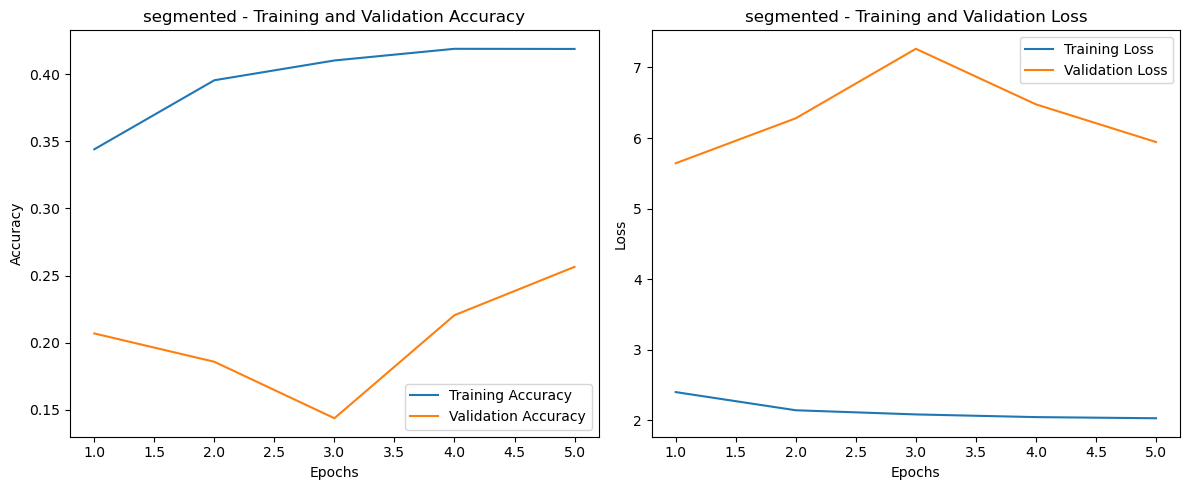

Training with ResNet model on greyscale dataset...
Found 37998 images belonging to 38 classes.
Found 16307 images belonging to 38 classes.
Epoch 1/5
1188/1188 [==============================] - 2620s 2s/step - loss: 2.4035 - accuracy: 0.3419 - val_loss: 9.1650 - val_accuracy: 0.1469
Epoch 2/5
1188/1188 [==============================] - 1578s 1s/step - loss: 2.1277 - accuracy: 0.4009 - val_loss: 10.3440 - val_accuracy: 0.1444
Epoch 3/5
1188/1188 [==============================] - 38155s 32s/step - loss: 2.0781 - accuracy: 0.4084 - val_loss: 8.1205 - val_accuracy: 0.1552
Epoch 4/5
1188/1188 [==============================] - 2288s 2s/step - loss: 2.0421 - accuracy: 0.4184 - val_loss: 6.3270 - val_accuracy: 0.1758
Epoch 5/5
510/510 [==============================] - 613s 1s/step - loss: 8.9127 - accuracy: 0.1001
Mode: greyscale | Test Accuracy: 0.10014104098081589


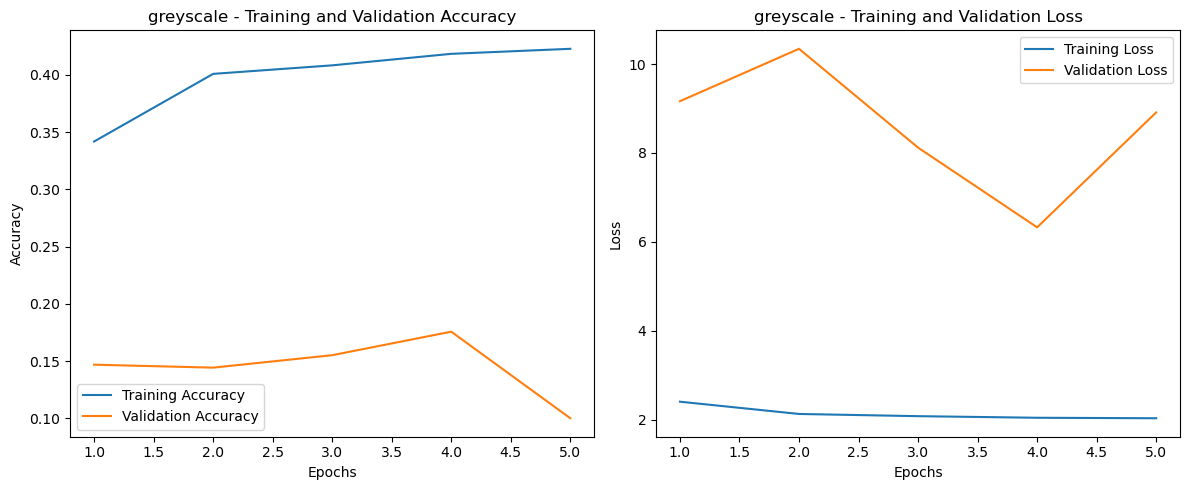

Training with ResNet model on color dataset...
Found 37998 images belonging to 38 classes.
Found 16307 images belonging to 38 classes.
Epoch 1/5
1188/1188 [==============================] - 1691s 1s/step - loss: 2.3334 - accuracy: 0.3597 - val_loss: 8.2521 - val_accuracy: 0.1691
Epoch 2/5
1188/1188 [==============================] - 1396s 1s/step - loss: 2.0108 - accuracy: 0.4323 - val_loss: 7.3090 - val_accuracy: 0.1272
Epoch 3/5
1188/1188 [==============================] - 2025s 2s/step - loss: 1.9611 - accuracy: 0.4455 - val_loss: 11.5509 - val_accuracy: 0.0659
Epoch 4/5
1188/1188 [==============================] - 2400s 2s/step - loss: 1.9144 - accuracy: 0.4549 - val_loss: 6.4982 - val_accuracy: 0.2216
Epoch 5/5
510/510 [==============================] - 355s 695ms/step - loss: 9.2890 - accuracy: 0.1136
Mode: color | Test Accuracy: 0.11357086151838303


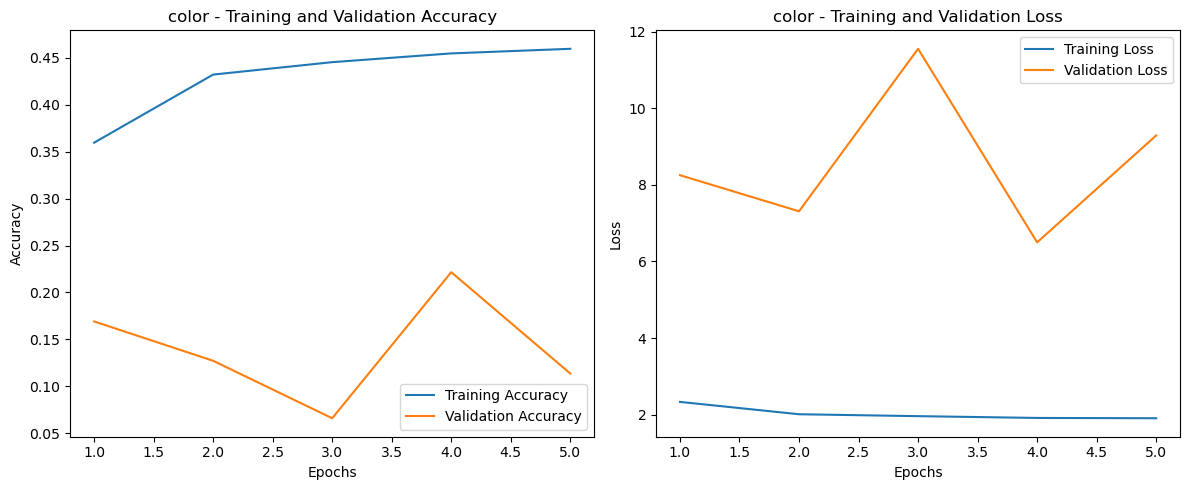

Training with VGG model on segmented dataset...
Found 37998 images belonging to 38 classes.
Found 16308 images belonging to 38 classes.
58889256/58889256 [==============================] - 52s 1us/step
Epoch 1/5
1188/1188 [==============================] - 12310s 10s/step - loss: 0.8125 - accuracy: 0.7577 - val_loss: 0.6288 - val_accuracy: 0.8069
Epoch 2/5
1188/1188 [==============================] - 3068s 3s/step - loss: 0.5503 - accuracy: 0.8243 - val_loss: 0.4923 - val_accuracy: 0.8424
Epoch 3/5
1188/1188 [==============================] - 3568s 3s/step - loss: 0.4978 - accuracy: 0.8409 - val_loss: 0.6004 - val_accuracy: 0.8078
Epoch 4/5
1188/1188 [==============================] - 2689s 2s/step - loss: 0.4764 - accuracy: 0.8452 - val_loss: 0.5615 - val_accuracy: 0.8247
Epoch 5/5
510/510 [==============================] - 779s 2s/step - loss: 0.4985 - accuracy: 0.8429
Mode: segmented | Test Accuracy: 0.8428992033004761


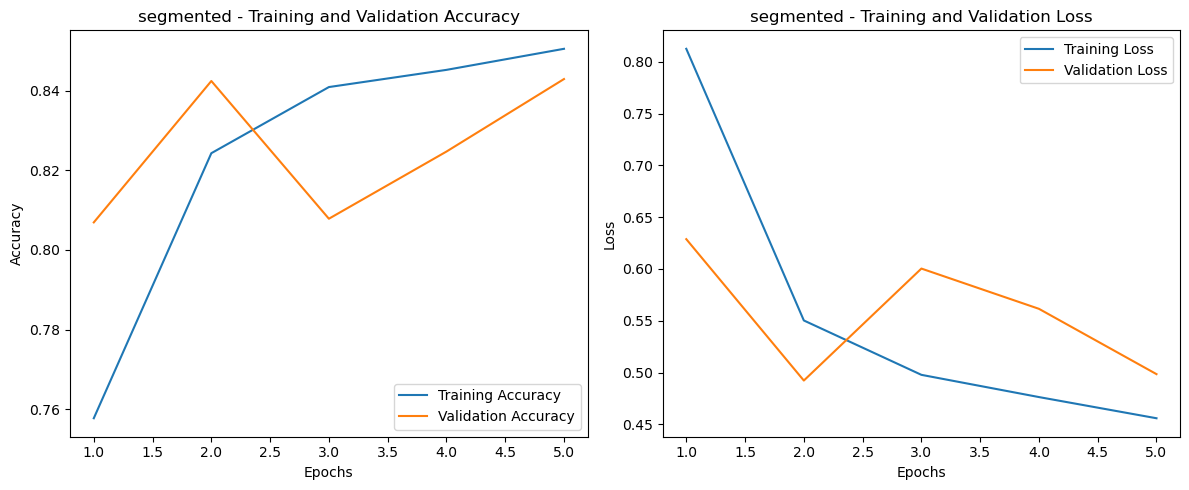

Training with VGG model on greyscale dataset...
Found 37998 images belonging to 38 classes.
Found 16307 images belonging to 38 classes.
Epoch 1/5
1188/1188 [==============================] - 2992s 3s/step - loss: 1.1371 - accuracy: 0.6639 - val_loss: 0.7809 - val_accuracy: 0.7548
Epoch 2/5
1188/1188 [==============================] - 38173s 32s/step - loss: 0.8253 - accuracy: 0.7403 - val_loss: 0.7004 - val_accuracy: 0.7775
Epoch 3/5
1188/1188 [==============================] - 2625s 2s/step - loss: 0.7805 - accuracy: 0.7508 - val_loss: 0.7022 - val_accuracy: 0.7835
Epoch 4/5
1188/1188 [==============================] - 2796s 2s/step - loss: 0.7518 - accuracy: 0.7602 - val_loss: 0.6936 - val_accuracy: 0.7867
Epoch 5/5
510/510 [==============================] - 817s 2s/step - loss: 0.7004 - accuracy: 0.7828
Mode: greyscale | Test Accuracy: 0.7827926874160767


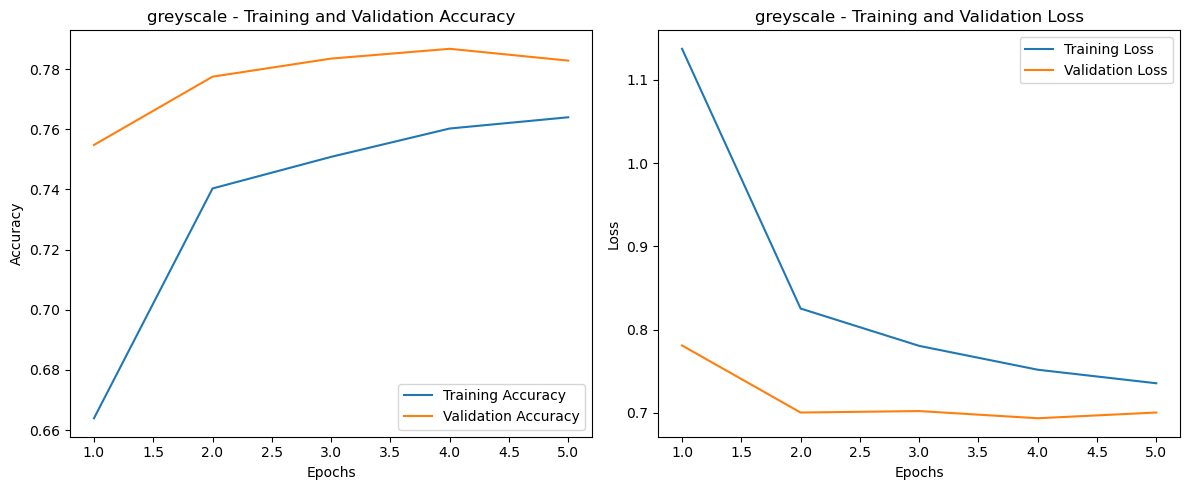

Training with VGG model on color dataset...
Found 37998 images belonging to 38 classes.
Found 16307 images belonging to 38 classes.
Epoch 1/5
1188/1188 [==============================] - 2727s 2s/step - loss: 0.8340 - accuracy: 0.7494 - val_loss: 0.6133 - val_accuracy: 0.8105
Epoch 2/5
1188/1188 [==============================] - 15319s 13s/step - loss: 0.5441 - accuracy: 0.8234 - val_loss: 0.4933 - val_accuracy: 0.8416
Epoch 3/5
1188/1188 [==============================] - 2933s 2s/step - loss: 0.5003 - accuracy: 0.8353 - val_loss: 0.5000 - val_accuracy: 0.8426
Epoch 4/5
1188/1188 [==============================] - 3137s 3s/step - loss: 0.4724 - accuracy: 0.8473 - val_loss: 0.5428 - val_accuracy: 0.8277
Epoch 5/5
510/510 [==============================] - 870s 2s/step - loss: 0.3964 - accuracy: 0.8725
Mode: color | Test Accuracy: 0.8725087642669678


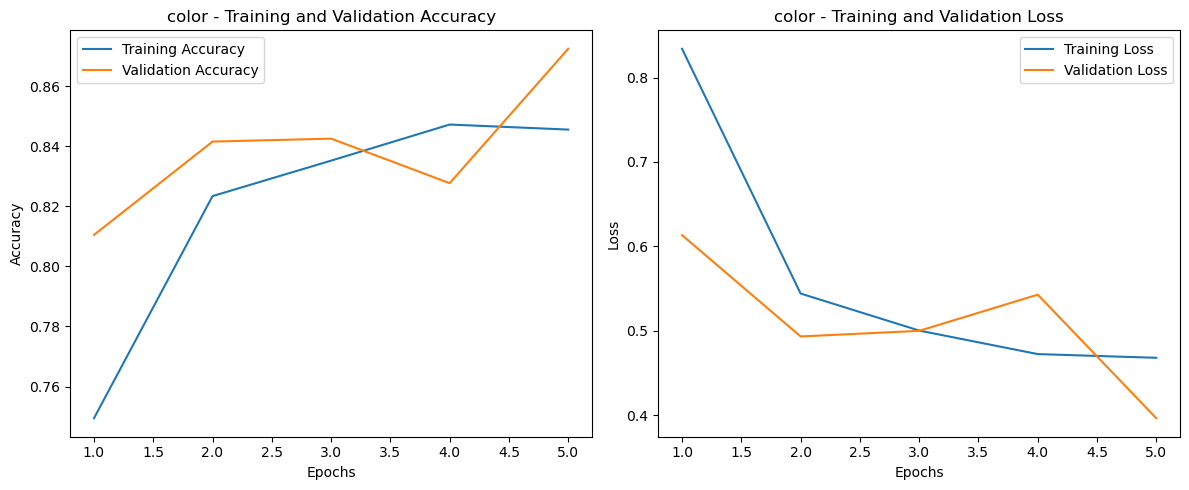

In [9]:
# Execute the main function
if __name__ == "__main__":
    main()